# Regression Analysis for Classification Projects

Since our project is not a classification project, we will be performing a regression analysis instead

In [14]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import xarray as xr
import pandas as pd
import deep_snow.dataset
import torch
from deep_snow.utils import calc_dowy, db_scale
from sklearn.preprocessing import MinMaxScaler
import os
from tqdm import tqdm

### Let's turn our netcdf data into a dataframe for the sake of the classic ml assignment

In [15]:
channel_map = {
    'aso_sd': 'aso_sd', 'snowon_vv': 'snowon_vv',
    'AOT': 'aerosol_optical_thickness', 'B01': 'coastal_aerosol',
    'B02': 'blue', 'B03': 'green', 'B04': 'red', 'B05': 'red_edge1',
    'B06': 'red_edge2', 'B07': 'red_edge3', 'B08': 'nir', 'B09': 'water_vapor',
    'B11': 'swir1', 'B12': 'swir2', 'SCL': 'scene_class_map', 
    'WVP': 'water_vapor_product', 'fcf': 'fcf', 'elevation': 'elevation',
    'slope': 'slope', 'aspect': 'aspect', 'curvature': 'curvature',
    'tri': 'tri', 'tpi': 'tpi', 'latitude': 'latitude', 
    'longitude': 'longitude'
}

In [16]:
# The resulting dataframe would be shape (46691645, 26) and requires more memory than I have to
# process, so we comment out the scaling code and just focus on a subset of the data
def generate_df(path_list, channel_map=channel_map):
    #scaler = MinMaxScaler()
    # Initialize empty DataFrame to store data
    all_data = pd.DataFrame()

    # Loop to process each NetCDF file
    for path in tqdm(path_list):
        ds = xr.open_dataset(path)
        
        # Extract file date and compute day of water year (dowy)
        fn = os.path.split(path)[-1]
        file_date = pd.to_datetime(fn.split('_')[4])
        dowy_1d = calc_dowy(file_date.dayofyear)

        # Flatten each channel and store it
        data = {}
        for netcdf_name, descriptive_name in channel_map.items():
            if netcdf_name in ds:
                data[netcdf_name] = ds[netcdf_name].values.flatten()
            else:
                data[netcdf_name] = np.full((128 * 128,), np.nan)
        
        # Fill in dowy as a constant array
        data['dowy'] = np.full((128 * 128,), dowy_1d)
        
        # Convert to DataFrame and append to all_data
        df = pd.DataFrame(data)
        all_data = pd.concat([all_data, df], ignore_index=True)
    
    all_data.rename(columns=channel_map, inplace=True)
    # Drop rows where 'red' or 'elevation' or 'tpi' are 0, weird way of handling missing values
    all_data = all_data[(all_data['red'] != 0) & (all_data['elevation'] != 0) & (all_data['tpi'] != 0)].reset_index(drop=True)

    # Filter rows to keep only those within 3 standard deviations for all columns
    means = all_data.mean()
    std_devs = all_data.std()
    filtered_data = all_data[(np.abs(all_data - means) <= 3 * std_devs).all(axis=1)].reset_index(drop=True)
    # Exclude 'aso_sd' from columns to be normalized
    #cols_to_normalize = [col for col in filtered_data.columns if col != 'aso_sd']

    # Normalize the selected columns
    #filtered_data[cols_to_normalize] = scaler.fit_transform(filtered_data[cols_to_normalize])
    return filtered_data

In [17]:
# process the data with the below paths
# due to the memory issues, i've processed splits of the data and have saved them as parquets
# even merging all of the dataframes is too computationally intensive
base_dir = '/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/subsets_v4'
train_list, test_list, val_list = [glob(f'{base_dir}/{subset}/ASO_50M_SD*.nc') for subset in ['train', 'test', 'val']]
#path_list = glob('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/subsets_v4/*/ASO_50M_SD*.nc')
# df = generate_df(path_list)
# df.to_parquet('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/classic_ml_v1.parquet')

In [18]:
df = pd.read_parquet('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/classic_ml_val_v1.parquet')

In [19]:
scaler = MinMaxScaler()
cols_to_normalize = [col for col in df.columns if col != 'aso_sd']
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

In [20]:
df
# 5.7 million obersvations, all minmax scaled
# subset of features chosen from our exploratory data analysis

,aso_sd,snowon_vv,aerosol_optical_thickness,coastal_aerosol,blue,green,red,red_edge1,red_edge2,red_edge3,...,fcf,elevation,slope,aspect,curvature,tri,tpi,latitude,longitude,dowy
0,0.000000,0.034741,0.451524,0.361875,0.353116,0.365153,0.375045,0.381241,0.439588,0.464821,...,0.25,0.444744,0.140537,0.827236,0.450719,0.124839,0.455258,0.785057,0.019264,0.056818
1,0.000000,0.018444,0.451524,0.595530,0.752536,0.755720,0.760649,0.789616,0.806356,0.801144,...,0.22,0.446390,0.023371,0.905367,0.770828,0.138894,0.722182,0.785054,0.019303,0.056818
2,0.000000,0.168401,0.451524,0.774610,0.882065,0.891728,0.898930,0.947582,0.970590,0.955312,...,0.27,0.444428,0.228046,0.230994,0.449177,0.195033,0.473952,0.785050,0.019342,0.056818
3,0.000000,0.048596,0.451524,0.522883,0.694983,0.710806,0.722003,0.752439,0.792577,0.797974,...,0.29,0.441090,0.289067,0.203127,0.166511,0.294096,0.210729,0.785047,0.019382,0.056818
4,0.000000,0.023445,0.451524,0.378733,0.435581,0.452939,0.464694,0.479667,0.541448,0.564868,...,0.29,0.439250,0.280976,0.165610,0.407580,0.260839,0.361191,0.785044,0.019421,0.056818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5763830,1.727720,0.023901,0.315789,0.359168,0.329828,0.351113,0.350146,0.384966,0.404712,0.411149,...,0.49,0.538305,0.173524,0.794490,0.603449,0.153912,0.611883,0.427330,0.072753,0.488636
5763831,1.751487,0.027005,0.315789,0.300994,0.234380,0.254415,0.259713,0.291105,0.343434,0.348338,...,0.45,0.539917,0.119889,0.842595,0.732065,0.147952,0.702783,0.427334,0.072792,0.488636
5763832,1.984806,0.034276,0.315789,0.292790,0.285065,0.306454,0.310888,0.319408,0.358333,0.376363,...,0.43,0.540108,0.077035,0.874038,0.548728,0.085517,0.564977,0.427337,0.072830,0.488636
5763833,2.033020,0.035219,0.315789,0.311469,0.266206,0.287028,0.294942,0.318999,0.363164,0.376548,...,0.42,0.540454,0.072002,0.788041,0.497317,0.073592,0.493066,0.427340,0.072868,0.488636


In [21]:
# that's still a bit too big, using the original dataframe made the inital model exploration too slow
# so let's use an even smaller subset before we scale up
# i randomly picked 500k rows
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
subset_df = shuffled_df.iloc[:500000]

In [28]:
y = subset_df.iloc[:,0].values
data = subset_df.iloc[:, 1:].values

In [29]:
from sklearn.model_selection import train_test_split
# Split data into 80% train and 20% test subsets
print(f"There are {data.shape[0]} data samples")
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.2, shuffle=True)

There are 500000 data samples


### Now, let's use sklearn to pick some initial regressors to explore with our data

In [24]:
# let's check what sklearn has in terms of regressors first
import inspect
from sklearn.utils import all_estimators 
# here, we see which ones have the 'sample_weight' parameter required for VotingRegressor()
for name, clf in all_estimators(type_filter='regressor'):
    if 'sample_weight' in inspect.signature(clf.fit).parameters:
        print(f"{name} supports sample_weight.")

AdaBoostRegressor supports sample_weight.
BaggingRegressor supports sample_weight.
BayesianRidge supports sample_weight.
DecisionTreeRegressor supports sample_weight.
DummyRegressor supports sample_weight.
ElasticNet supports sample_weight.
ElasticNetCV supports sample_weight.
ExtraTreeRegressor supports sample_weight.
ExtraTreesRegressor supports sample_weight.
GammaRegressor supports sample_weight.
GradientBoostingRegressor supports sample_weight.
HistGradientBoostingRegressor supports sample_weight.
HuberRegressor supports sample_weight.
IsotonicRegression supports sample_weight.
KernelRidge supports sample_weight.
Lasso supports sample_weight.
LassoCV supports sample_weight.
LinearRegression supports sample_weight.
LinearSVR supports sample_weight.
MultiOutputRegressor supports sample_weight.
NuSVR supports sample_weight.
PoissonRegressor supports sample_weight.
QuantileRegressor supports sample_weight.
RANSACRegressor supports sample_weight.
RandomForestRegressor supports sample_w

In [31]:
# ideally, i'd want to test all of these, but given the size of our data, that would take way too long
# even just assessing the Support Vector Regressor took >15 minutes on 500,000-observatio dataset
# this is infeasible for the full dataset (nearly ~50 million observations) so for now, we'll just inspect
# some of the fastest regressors given the goal of this project is to improve upon an
# already-built deep CNN

# i initally wanted to test:
# SVR
# RandomForestRegressor
# ElasticNet
# QuantileRegressor
# GradientBoostingRegressor

# that being said, if we had more computational resources rather than our local machines, we would
# test all of these initial regressors with no parameters to assess preliminary results before moving on
# say plugging ~5 million observations into each model and running it on a job overnight on an HPC
# or spinning up a super short-termed cloud instance
from sklearn import metrics
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import VotingRegressor

# ElasticNet Regressor
en_reg = ElasticNet()
en_reg.fit(X_train, y_train) 
en_prediction = en_reg.predict(X_test)
print("ElasticNet Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=en_prediction))

# Ridge Regressor
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
ridge_prediction = ridge_reg.predict(X_test)
print("Ridge Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=ridge_prediction))

# Lasso Regressor
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
lasso_prediction = lasso_reg.predict(X_test)
print("Lasso Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=lasso_prediction))

# Dummy Regressor (Baseline)
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)
dummy_prediction = dummy_reg.predict(X_test)
print("Dummy Regressor Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=dummy_prediction))

# Voting Regressor (Dummy and Ridge)
voting_reg = VotingRegressor(estimators=[('dummy', dummy_reg), ('ridge', ridge_reg)])
voting_reg.fit(X_train, y_train)
voting_prediction = voting_reg.predict(X_test)
print("Voting Regressor (Dummy + Ridge) Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=voting_prediction))

ElasticNet Mean Absolute Error: 0.6311615890991946
Ridge Mean Absolute Error: 0.48077285341550857
Lasso Mean Absolute Error: 0.6311615890991946
Dummy Regressor Mean Absolute Error: 0.4688792
Voting Regressor (Dummy + Ridge) Mean Absolute Error: 0.4430731555166684


In [32]:
# great, that was super quick, now let's try the same regressors with more data - the 5.7 million
y = df.iloc[:,0].values
data = df.iloc[:, 1:].values
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, shuffle=True)
# ElasticNet Regressor
en_reg = ElasticNet()
en_reg.fit(X_train, y_train) 
en_prediction = en_reg.predict(X_test)
print("ElasticNet Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=en_prediction))

# Ridge Regressor
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
ridge_prediction = ridge_reg.predict(X_test)
print("Ridge Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=ridge_prediction))

# Lasso Regressor
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
lasso_prediction = lasso_reg.predict(X_test)
print("Lasso Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=lasso_prediction))

# Dummy Regressor (Baseline)
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)
dummy_prediction = dummy_reg.predict(X_test)
print("Dummy Regressor Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=dummy_prediction))

# Voting Regressor (Dummy and Ridge)
voting_reg = VotingRegressor(estimators=[('dummy', dummy_reg), ('ridge', ridge_reg)])
voting_reg.fit(X_train, y_train)
voting_prediction = voting_reg.predict(X_test)
print("Voting Regressor (Dummy + Ridge) Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=voting_prediction))

ElasticNet Mean Absolute Error: 0.6301796462058924
Ridge Mean Absolute Error: 0.48047760970918885
Lasso Mean Absolute Error: 0.6301796462058924
Dummy Regressor Mean Absolute Error: 0.46853846
Voting Regressor (Dummy + Ridge) Mean Absolute Error: 0.4429800095283347


In [ ]:
# we see above that all of the models are very poor at predicting snow depth
# an error of +- 0.44 meters of snow depth is simply unacceptable and a big reason as to why we're
# focusing on improving upon deep learning models
# yes, we didn't test all of the classic ML models we wanted to look at due to computational constraints
# but this is evidence as to why we're focusing on improving upon deep learning models

# that being said, the voting regressor seems to be performing the best, let's assess the robustness of these
# preliminary results, though

In [ ]:
# like how the assignment says to assess clustering robustness and optimal 'k' values
# we'll do our own spin on it for regression

# let's see how these models do with cross validations
from sklearn.model_selection import cross_val_score
models = {
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Dummy": DummyRegressor(strategy="median"),
    "Voting": VotingRegressor(estimators=[('dummy', dummy_reg), ('ridge', ridge_reg)])
}

# evaluate each model with repeated cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', error_score='raise')
    print(f"{name} - Mean Absolute Error (5-fold CV): {np.mean(-scores):.4f} ± {np.std(-scores):.4f}")

ElasticNet - Mean Absolute Error (5-fold CV): 0.6300 ± 0.0004
Ridge - Mean Absolute Error (5-fold CV): 0.4801 ± 0.0002
Lasso - Mean Absolute Error (5-fold CV): 0.6300 ± 0.0004
Dummy - Mean Absolute Error (5-fold CV): 0.4688 ± 0.0005
Voting - Mean Absolute Error (5-fold CV): 0.4429 ± 0.0003


In [ ]:
# we see above that are previous assumptions about the base voting regressor outperforming the others
# is supported by the cross-validation scores and standard deviations

# interestingly, all of the models have a lower standard deviation

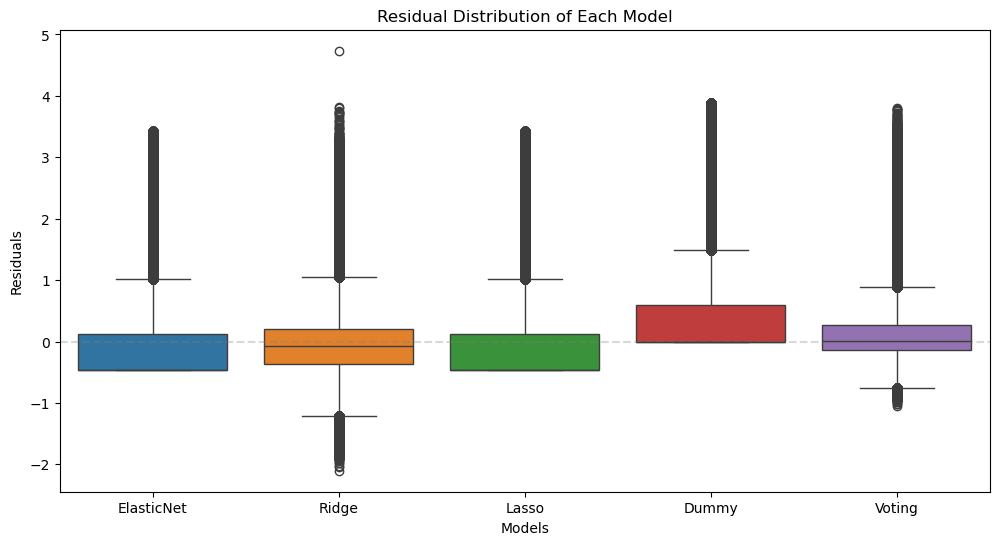

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# residual plotting
residuals = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    residuals[name] = y_test - predictions

plt.figure(figsize=(12, 6))
sns.boxplot(data=pd.DataFrame(residuals))
plt.axhline(0, color='gray', linestyle='--', alpha=0.3)
plt.title("Residual Distribution of Each Model")
plt.ylabel("Residuals")
plt.xlabel("Models")
plt.show()

In [ ]:
# we do see from plotting the residuals how ridiculously high the errors are
# this is understandable as predicting snow depth using remote sensing data over areas of complex topography and dense forest coverage
# is a very difficult task
# (our study are has a lot of complex topography and dense forest coverage)